In [ ]:
# default_exp models

# Noisy CMR
The Context Maintenance and Retrieval (CMR) as specified by Morton and Polyn (2016) takes the form of a simplified neural network with two interacting representations, a feature-based representation of the studied item and a contextual representation (the context layer, $C$). The two layers communicate with one another through two sets of associative connections represented by matrices $M^{FC}$ and $M^{CF}$. Each of these weight matrices contains both pre-experimental associations and new associations learned during the experiment.

In [ ]:
# export

import numpy as np
from numba import float64, int32, boolean
from numba.experimental import jitclass

ncmr_spec = [
    ('item_count', int32), 
    ('encoding_drift_rate', float64),
    ('start_drift_rate', float64),
    ('recall_drift_rate', float64),
    ('delay_drift_rate', float64),
    ('shared_support', float64),
    ('item_support', float64),
    ('learning_rate', float64),
    ('primacy_scale', float64),
    ('primacy_decay', float64),
    ('stop_probability_scale', float64),
    ('stop_probability_growth', float64),
    ('choice_sensitivity', float64),
    ('context_sensitivity', float64),
    ('feature_sensitivity', float64),
    ('context', float64[::1]),
    ('start_context_input', float64[::1]),
    ('delay_context_input', float64[::1]),
    ('preretrieval_context', float64[::1]),
    ('recall', int32[::1]),
    ('retrieving', boolean),
    ('recall_total', int32),
    ('item_weighting', float64[::1]),
    ('context_weighting', float64[::1]),
    ('all_weighting', float64[::1]),
    ('probabilities', float64[::1]),
    ('memory', float64[:,::1]),
    ('encoding_index', int32),
    ('items', float64[:,::1]),
    ('norm', float64[::1]),
    ('contextual_input', float64[:, ::1])
]

In [ ]:
# export
noise = np.random.rand(80, 42)

In [ ]:
# export

@jitclass(ncmr_spec)
class Noisy_CMR:

    def __init__(self, item_count, presentation_count, parameters):

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = parameters['encoding_drift_rate']
        self.delay_drift_rate = parameters['delay_drift_rate']
        self.start_drift_rate = parameters['start_drift_rate']
        self.recall_drift_rate = parameters['recall_drift_rate']
        self.shared_support = parameters['shared_support']
        self.item_support = parameters['item_support']
        self.learning_rate = parameters['learning_rate']
        self.primacy_scale = parameters['primacy_scale']
        self.primacy_decay = parameters['primacy_decay']
        self.stop_probability_scale = parameters['stop_probability_scale']
        self.stop_probability_growth = parameters['stop_probability_growth']
        self.choice_sensitivity = parameters['choice_sensitivity']
        self.context_sensitivity = parameters['context_sensitivity']
        self.feature_sensitivity = parameters['feature_sensitivity']
        
        # at the start of the list context is initialized with a state 
        # orthogonal to the pre-experimental context associated with the set of items
        self.context = np.zeros(item_count + 2)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count, int32) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine activation weighting vectors
        self.item_weighting = np.ones(item_count+presentation_count)
        self.context_weighting = np.ones(item_count+presentation_count)
        self.item_weighting[item_count:] = self.learning_rate
        self.context_weighting[item_count:] = \
            self.primacy_scale * np.exp(-self.primacy_decay * np.arange(presentation_count)) + 1
        self.all_weighting = self.item_weighting * self.context_weighting

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # predefine contextual input vectors relevant for delay_drift_rate and start_drift_rate parameters
        self.start_context_input = np.zeros((self.item_count+2))
        self.start_context_input[0] = 1
        self.delay_context_input = np.zeros((self.item_count+2))
        self.delay_context_input[-1] = 1

        # initialize memory
        # we now conceptualize it as a pairing of two stores Mfc and Mcf respectively
        # representing feature-to-context and context-to-feature associations
        mfc = np.eye(item_count, item_count + 2, 1) * (1 - self.learning_rate)
        mcf = np.ones((item_count, item_count)) * self.shared_support
        for i in range(item_count):
            mcf[i, i] = self.item_support
        mcf = np.hstack((np.zeros((item_count, 1)), mcf,  np.zeros((item_count, 1))))
        self.memory = np.zeros((item_count + presentation_count, item_count * 2 + 4))
        self.memory[:item_count,] = np.hstack((mfc, mcf))

        self.norm = np.zeros(item_count + presentation_count)
        self.norm[:item_count] = np.sqrt(np.sum(np.square(self.memory[0])))
        self.norm[item_count:] = np.sqrt(2)
        self.encoding_index = item_count
        self.items = np.hstack((np.eye(item_count, item_count + 2, 1), np.zeros((item_count, item_count+2))))

        self.contextual_input = noise.copy()

    def experience(self, experiences):

        for i in range(len(experiences)):
            self.memory[self.encoding_index] = experiences[i]
            self.update_context(self.encoding_drift_rate, self.memory[self.encoding_index])
            self.memory[self.encoding_index, self.item_count+2:] = self.context
            self.encoding_index += 1

    def update_context(self, drift_rate, experience):

        # first pre-experimental or initial context is retrieved
        if len(experience) == self.item_count * 2 + 4:

            # if the context is not pre-experimental, the context is retrieved
            #context_input = self.echo(experience)[self.item_count + 2:]
            context_input = self.contextual_input[self.encoding_index + self.recall_total - self.item_count]
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
            
        else:
            context_input = experience

        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(drift_rate) * (np.square(self.context * context_input) - 1)) - (
                drift_rate * (self.context * context_input))
        self.context = (rho * self.context) + (drift_rate * context_input)
        self.context = self.context / np.sqrt(np.sum(np.square(self.context)))

    def echo(self, probe):

        return np.dot(self.activations(probe), self.memory[:self.encoding_index])

    def activations(self, probe, probe_norm=1.0):

        activation = np.dot(self.memory[:self.encoding_index], probe) / (
             self.norm[:self.encoding_index] * probe_norm)

        # weight activations based on whether probe contains item or contextual features or both
        if np.any(probe[:self.item_count + 2]): # if probe is an item feature cue as during contextual retrieval
            if np.any(probe[self.item_count + 2:]): # if probe is (also) a contextual cue as during item retrieval
                # both mfc and mcf weightings, see below
                activation *= self.all_weighting[:self.encoding_index]
            else:
                # mfc weightings - scale by gamma for each experimental trace
                activation *= self.item_weighting[:self.encoding_index]
            activation = np.power(activation, self.context_sensitivity)
        else:
            # mcf weightings - scale by primacy/attention function based on experience position
            activation *= self.context_weighting[:self.encoding_index]
            if self.feature_sensitivity != 1.0:
                activation = np.power(activation, self.feature_sensitivity)
            else:
                activation = np.power(activation, self.context_sensitivity)
            
        return activation + 10e-7

    def outcome_probabilities(self):
        
        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0 - (
                 (self.item_count-self.recall_total) * 10e-7))
        self.probabilities[1:] = 10e-7

        if self.probabilities[0] < (1.0 - ((self.item_count-self.recall_total) * 10e-7)):

            # measure activation for each item
            activation_cue = np.hstack((np.zeros(self.item_count + 2), self.context))
            activation = self.echo(activation_cue)[1:self.item_count+1]

            # already recalled items have zero activation
            activation[self.recall[:self.recall_total]] = 0
            
            # recall probability is a function of activation
            if np.sum(activation) > 0:
                activation = np.power(activation, self.choice_sensitivity)
                self.probabilities[1:] = (1-self.probabilities[0]) * activation / np.sum(activation)
        
        return self.probabilities

    def free_recall(self, steps=None):

        # some pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.delay_drift_rate, self.delay_context_input)
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True
            
        # number of items to retrieve is infinite if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps

        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to 
            # attempt recall of a studied item compute outcome probabilities 
            # and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities()
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(
                    np.cumsum(outcome_probabilities) < np.random.rand(), dtype=int32)
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        return self.recall[:self.recall_total]
    
    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.delay_drift_rate, self.delay_context_input)
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(
                self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

In [ ]:
int32 = int

#@jitclass(ncmr_spec)
class Noise_CMR:

    def __init__(self, item_count, presentation_count, parameters):

        # store initial parameters
        self.item_count = item_count
        self.encoding_drift_rate = parameters['encoding_drift_rate']
        self.start_drift_rate = parameters['start_drift_rate']
        self.recall_drift_rate = parameters['recall_drift_rate']
        self.shared_support = parameters['shared_support']
        self.item_support = parameters['item_support']
        self.learning_rate = parameters['learning_rate']
        self.primacy_scale = parameters['primacy_scale']
        self.primacy_decay = parameters['primacy_decay']
        self.stop_probability_scale = parameters['stop_probability_scale']
        self.stop_probability_growth = parameters['stop_probability_growth']
        self.choice_sensitivity = parameters['choice_sensitivity']
        self.sampling_rule = parameters['sampling_rule']
        
        # at the start of the list context is initialized with a state 
        # orthogonal to the pre-experimental context
        # associated with the set of items
        self.context = np.zeros(item_count + 2)
        self.context[0] = 1
        self.preretrieval_context = self.context
        self.recall = np.zeros(item_count, int32) # recalls has at most `item_count` entries
        self.retrieving = False
        self.recall_total = 0

        # predefine primacy weighting vectors
        self.primacy_weighting = parameters['primacy_scale'] * np.exp(
            -parameters['primacy_decay'] * np.arange(presentation_count)) + 1

        # preallocate for outcome_probabilities
        self.probabilities = np.zeros((item_count + 1))

        # predefine contextual input vectors relevant for start_drift_rate parameters
        self.start_context_input = np.zeros((self.item_count+2))
        self.start_context_input[0] = 1

        # The two layers communicate with one another through two sets of 
        # associative connections represented by matrices Mfc and Mcf. 
        # Pre-experimental Mfc is 1-learning_rate and pre-experimental Mcf is
        # item_support for i=j. For i!=j, Mcf is shared_support.
        self.mfc = np.eye(item_count, item_count+2, 1) * (1-self.learning_rate)
        self.mcf = np.ones((item_count, item_count)) * self.shared_support
        for i in range(item_count):
            self.mcf[i, i] = self.item_support
        self.mcf =  np.vstack((np.zeros((1, item_count)), self.mcf, np.zeros((1, item_count))))
        self.encoding_index = 0
        self.items = np.eye(item_count, item_count)
        
        self.contextual_input = 0

    def experience(self, experiences):
        
        for i in range(len(experiences)):

            self.update_context(self.encoding_drift_rate, experiences[i])
            self.mfc += self.learning_rate * np.outer(self.context, experiences[i]).T
            self.mcf += self.primacy_weighting[self.encoding_index] * np.outer(
                self.context, experiences[i])
            self.encoding_index += 1

    def update_context(self, drift_rate, experience):

        # first pre-experimental or initial context is retrieved
        if len(experience) == len(self.mfc):

            # if the context is not pre-experimental, the context is retrieved
            context_input = self.contextual_input[self.encoding_index + self.recall_total]
            context_input = context_input / np.sqrt(np.sum(np.square(context_input))) # norm to length 1
            
        else:
            context_input = experience
  
        # updated context is sum of context and input, modulated by rho to have len 1 and some drift_rate
        rho = np.sqrt(1 + np.square(min(drift_rate, 1.0)) * (
            np.square(self.context * context_input) - 1)) - (
                min(drift_rate, 1.0) * (self.context * context_input))
        self.context = (rho * self.context) + (min(drift_rate, 1.0) * context_input)

    def activations(self, probe, use_mfc=False):

        if use_mfc:
            return np.dot(probe, self.mfc) + 10e-7
        else:
            return np.dot(probe, self.mcf) + 10e-7

    def outcome_probabilities(self):

        self.probabilities[0] = min(self.stop_probability_scale * np.exp(
            self.recall_total * self.stop_probability_growth), 1.0 - (
                 (self.item_count-self.recall_total) * 10e-7))
        self.probabilities[1:] = 10e-7

        if self.probabilities[0] < (1.0 - ((self.item_count-self.recall_total) * 10e-7)):

            # measure the activation for each item
            activation = self.activations(self.context)

            # already recalled items have zero activation
            activation[self.recall[:self.recall_total]] = 0

            if np.sum(activation) > 0:

                # power sampling rule vs modified exponential sampling rule
                if self.sampling_rule == 0:
                    activation = np.power(activation, self.choice_sensitivity)
                else:
                    pre_activation = (2 * activation)/ self.choice_sensitivity
                    activation = np.exp(pre_activation - np.max(pre_activation))
                
                # normalized result downweighted by stop prob is probability of choosing each item
                self.probabilities[1:] = (1-self.probabilities[0]) * activation / np.sum(activation)
            
        return self.probabilities

    def free_recall(self, steps=None):

        # some amount of the pre-list context is reinstated before initiating recall
        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True

        # number of items to retrieve is # of items left to recall if steps is unspecified
        if steps is None:
            steps = self.item_count - self.recall_total
        steps = self.recall_total + steps
        
        # at each recall attempt
        while self.recall_total < steps:

            # the current state of context is used as a retrieval cue to attempt recall of a studied item
            # compute outcome probabilities and make choice based on distribution
            outcome_probabilities = self.outcome_probabilities()
            if np.any(outcome_probabilities[1:]):
                choice = np.sum(np.cumsum(outcome_probabilities) < np.random.rand(), dtype=int32)
            else:
                choice = 0

            # resolve and maybe store outcome
            # we stop recall if no choice is made (0)
            if choice == 0:
                self.retrieving = False
                self.context = self.preretrieval_context
                break
                
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        return self.recall[:self.recall_total]

    def force_recall(self, choice=None):

        if not self.retrieving:
            self.recall = np.zeros(self.item_count, int32)
            self.recall_total = 0
            self.preretrieval_context = self.context
            self.update_context(self.start_drift_rate, self.start_context_input)
            self.retrieving = True

        if choice is None:
            pass
        elif choice > 0:
            self.recall[self.recall_total] = choice - 1
            self.recall_total += 1
            self.update_context(self.recall_drift_rate, self.items[choice - 1])
        else:
            self.retrieving = False
            self.context = self.preretrieval_context
        return self.recall[:self.recall_total]

## Fitting Murdock 1970 Dataset
Must update to reflect shift to instance model. But in practice I'll probably move to a different notebook.

In [ ]:
from compmemlearn.datasets import prepare_murdock1970_data
#from compmemlearn.fitting import murdock_objective_function
from scipy.optimize import differential_evolution
from numba import njit
import numpy as np
from compmemlearn.fitting import apply_and_concatenate
import seaborn as sns
from numba.typed import Dict
from numba.core import types
from compmemlearn.datasets import simulate_df
import matplotlib.pyplot as plt
from psifr import fr

In [ ]:
def murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters):

    result = 0.0
    for i in range(len(item_counts)):
        item_count = item_counts[i]
        trials = data_to_fit[i]
        likelihood = np.ones((len(trials), item_count))

        model = model_class(item_count, item_count, parameters)
        model.experience(model.items)

        for trial_index in range(len(trials)):
            trial = trials[trial_index]

            model.force_recall()
            for recall_index in range(len(trial) + 1):

                # identify index of item recalled; if zero then recall is over
                if recall_index == len(trial) and len(trial) < item_count:
                    recall = 0
                else:
                    recall = trial[recall_index]

                # store probability of and simulate recall of indexed item 
                likelihood[trial_index, recall_index] = \
                    model.outcome_probabilities()[recall] + 10e-7
                
                if recall == 0:
                    break
                model.force_recall(recall)

            # reset model to its pre-retrieval (but post-encoding) state
            model.force_recall(0)
        
        result -= np.sum(np.log(likelihood))

    return result

def murdock_objective_function(data_to_fit, item_counts, model_class, fixed_parameters, free_parameters):
    """
    Configures cmr_likelihood for search over specified free/fixed parameters.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return murdock_data_likelihood(data_to_fit, item_counts, model_class, parameters)

    return objective_function

In [ ]:
trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')

In [ ]:
free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = (
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
)

#@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Noise_CMR(item_count, presentation_count, parameters)
    
cost_function = murdock_objective_function(
    (trials, ),  
    (list_length, ),
    init_cmr,
    {'sampling_rule': 0}, 
    free_parameters)

murdock_result = differential_evolution(cost_function, bounds, disp=True)

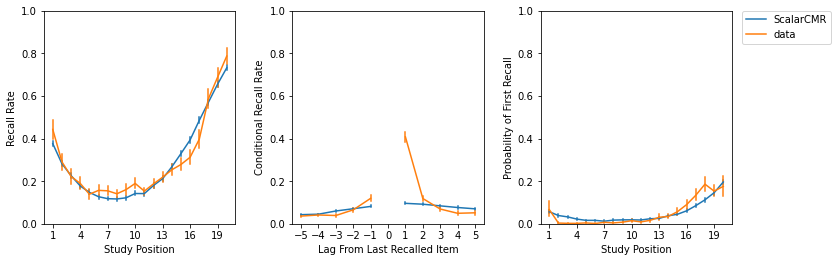

In [ ]:
fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(murdock_result.x)):
    fitted_parameters[free_parameters[i]] = murdock_result.x[i]
fitted_parameters['sampling_rule'] = 0

model0 = Noise_CMR(20, 20, fitted_parameters)

sim_df0 = simulate_df(model0, 5000)
true_df0 = events

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['ScalarCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['ScalarCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['ScalarCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12/3), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, list_length+1, 3))
axes[0].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2], hue='source', legend=True)
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, list_length+1, 3))
axes[2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)

## 